調參status: 
** batch= 64
** learning rate = 1e-3

** epoch=15
** loss function = loss_weights

目標: 將training dataset全部導入training，並使用loss_weights參數調笑使其達成平衡，避免drop out 影像重要節點

1. 建立early stopping， 若條件符合，調高學習率
2. 整份training datapreprocessing 匯入，並使用正確的weight loss
3. epoch 調高

Note: weighted_cross_entropy_with_logits is the weighted variant of sigmoid_cross_entropy_with_logits. It's for binary classification.

-- Change loss function (for example to focal loss for binary classification with extreme imbalance)

-- Oversampling and Undersampling, Upsample, downsample

-- Setting class weights

-- Use specific algorithm that are build to address this problem e.g. siamese network which is very useful when you only say have very few training sample of object of interest.

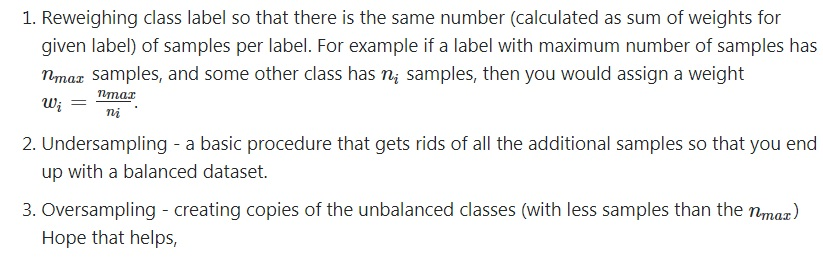

Ref:

1.changeable loss weights for multiple output
 https://github.com/keras-team/keras/issues/2595 

 https://github.com/keras-team/keras/issues/6446

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras_bert

  Created wheel for keras-bert: filename=keras_bert-0.88.0-cp37-none-any.whl size=34206 sha256=8ee2d7d6f0d637f871f2919f790baeb04a0bda2e57c662c666c3d5e05cb146c1
  Stored in directory: /root/.cache/pip/wheels/7f/d8/86/b4d91b941f6f3256c487b258d5e4268a3301203b717dd11f11
  Created wheel for keras-transformer: filename=keras_transformer-0.39.0-cp37-none-any.whl size=12841 sha256=f5ce1a1574829e544afc04bca4784c6a394b7dcfef9ba00c07366fc5a46bb336
  Stored in directory: /root/.cache/pip/wheels/77/42/35/d33c5907bca04ac5742e9eceefb644b680286de26728506a70
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.12.0-cp37-none-any.whl size=7471 sha256=687f91b9fce99425f07c09dd4de700fe8b227755cd6673815af5e82684f7565c
  Stored in directory: /root/.cache/pip/wheels/36/d8/36/06ed09215806dca9ff504d8c0dda5da68d7f2c67d34a231d82
  Created wheel for keras-multi-head: filename=keras_multi_head-0.28.0-cp37-none-any.whl size=15559 sha256=4279ca13b8f111fa89c07dbb4f41fe5bba4091c21eee434f63d355c707060a51
  Stor

In [ ]:
import codecs
import os
import sys
import pandas as pd
import numpy as np
import keras
from keras import Input, Model, losses, applications, datasets, wrappers
from keras.layers import Lambda, Dense
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras_bert import Tokenizer, load_trained_model_from_checkpoint

#絕對路徑 請自行建立副本並重設路徑
config_path = '/content/drive/MyDrive/AI_&_EdgeComputing_Program/NLP/NLP專案/專案程式碼(共用)/chinese_L-12_H-768_A-12/bert_config.json'# 加載配置文件
checkpoint_path = '/content/drive/MyDrive/AI_&_EdgeComputing_Program/NLP/NLP專案/專案程式碼(共用)/chinese_L-12_H-768_A-12/bert_model.ckpt'
dict_path = '/content/drive/MyDrive/AI_&_EdgeComputing_Program/NLP/NLP專案/專案程式碼(共用)/chinese_L-12_H-768_A-12/vocab.txt'

# 以下內容是Bert-Pre-training (英文的) 路徑要重設
# config_path = '/content/drive/MyDrive/yolo/kerasbert/uncased_L-12_H-768_A-12/bert_config.json'# 加載配置文件
# checkpoint_path = '/content/drive/MyDrive/yolo/kerasbert/uncased_L-12_H-768_A-12/bert_model.ckpt'
# dict_path = '/content/drive/MyDrive/yolo/kerasbert/uncased_L-12_H-768_A-12/vocab.txt'

maxlen=512 # 句子的最大長度，padding要用的 max 512 (兩個句子相加若超過512，第2個句子會被截掉)
# PY#爬蟲設定抓取字數 #爬蟲爬任何一段文字 要設定一個len max 250  # content 才需要 進階: 抓重要的字

In [ ]:
def get_token_dict(dict_path):
    '''
    :param: dict_path: 是bert模型的vocab.txt文件
    :return:將文件中字進行編碼
    '''
    # 將bert模型中的字進行編碼
    # 目的是喂入模型的是編碼
    token_dict = {}
    with codecs.open(dict_path, 'r', 'utf-8') as reader:
        for line in reader:
            token = line.strip()
            token_dict[token] = len(token_dict)
    return token_dict

In [ ]:
token_dict = get_token_dict(dict_path)
print(token_dict)

{'[PAD]': 0, '[unused1]': 1, '[unused2]': 2, '[unused3]': 3, '[unused4]': 4, '[unused5]': 5, '[unused6]': 6, '[unused7]': 7, '[unused8]': 8, '[unused9]': 9, '[unused10]': 10, '[unused11]': 11, '[unused12]': 12, '[unused13]': 13, '[unused14]': 14, '[unused15]': 15, '[unused16]': 16, '[unused17]': 17, '[unused18]': 18, '[unused19]': 19, '[unused20]': 20, '[unused21]': 21, '[unused22]': 22, '[unused23]': 23, '[unused24]': 24, '[unused25]': 25, '[unused26]': 26, '[unused27]': 27, '[unused28]': 28, '[unused29]': 29, '[unused30]': 30, '[unused31]': 31, '[unused32]': 32, '[unused33]': 33, '[unused34]': 34, '[unused35]': 35, '[unused36]': 36, '[unused37]': 37, '[unused38]': 38, '[unused39]': 39, '[unused40]': 40, '[unused41]': 41, '[unused42]': 42, '[unused43]': 43, '[unused44]': 44, '[unused45]': 45, '[unused46]': 46, '[unused47]': 47, '[unused48]': 48, '[unused49]': 49, '[unused50]': 50, '[unused51]': 51, '[unused52]': 52, '[unused53]': 53, '[unused54]': 54, '[unused55]': 55, '[unused56]': 5

In [ ]:
#中文才要開
#英文Tokenizer
class OurTokenizer(Tokenizer):

    def _tokenize(self, text):
        R = []
        for c in text:
            if c in self._token_dict:
                R.append(c)
            elif self._is_space(c):
                R.append('[unused1]') # 用[unused1]来表示空格类字符
            else:
                R.append('[UNK]')  # 不在列表的字符用[UNK]表示   UNK是unknown的意思
        return R

# Raw Data 前處理
將欄位切割成我們模型需要的欄位
- part 1 : train data

- part 2 : test data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## part 1 : train data

In [ ]:
#查看資料
import pandas as pd 

df_train = pd.read_csv('/content/drive/MyDrive/AI_&_EdgeComputing_Program/NLP/NLP專案/WSDM-testing dataset/train.csv')
#除空 dataframe 的masked 遮罩
empty_title = ((df_train['title2_zh'].isnull()) \
              | (df_train['title1_zh'].isnull()) \
              | (df_train['title2_zh'] == '') \
              | (df_train['title2_zh'] == '0')\
              | (df_train['label'].isnull()\
              | (df_train['label'] == '')))
##label 的unknown ######   
df_train = df_train[~empty_title] 
#~相反



In [ ]:
print(df_train.shape[0])
#證實已經去除任一重要特徵不全的資料後有320543萬筆
df_train.head()

320543


,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
0,0,0,1,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,There are two new old-age insurance benefits f...,"Police disprove ""bird's nest congress each per...",unrelated
1,3,2,3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP outstrips Hong Kong? Shenzhen S...,unrelated
2,1,2,4,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,"""If you do not come to Shenzhen, sooner or lat...",The GDP overtopped Hong Kong? Shenzhen clarifi...,unrelated
3,2,2,5,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,"""If you do not come to Shenzhen, sooner or lat...",Shenzhen's GDP topped Hong Kong last year? She...,unrelated
4,9,6,7,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,"""How to discriminate oil from gutter oil by me...",It took 30 years of cooking oil to know that o...,agreed


In [ ]:
#了解資料平衡性

cos = df_train.label.value_counts() / len(df_train)
print(round(cos,3))
#不平衡 要重組資料，鑑於disagreed (0.025787)太少，不採用乘上倒數weight的方式



#隨手清掉不重要特徵(也可放後面)
df_train = df_train.drop(columns=['id','tid1','tid2','title1_en','title2_en'])
df_train.head()

unrelated    0.684
agreed       0.290
disagreed    0.026
Name: label, dtype: float64


,title1_zh,title2_zh,label
0,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,unrelated
1,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,unrelated
2,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,unrelated
3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,unrelated
4,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,agreed


# Selecting Data to balance it

In [ ]:
three_category_count = []

###Train_agreed

In [ ]:
df_train_agreed = df_train[df_train['label']=='agreed']
three_category_count.append(len(df_train_agreed))
print('df_train_agreed_length:', len(df_train_agreed))
df_train_agreed.head()

df_train_agreed_length: 92965


,title1_zh,title2_zh,label
4,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,agreed
9,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",一颗大蒜就能鉴别地沟油？别闹了！做到下面几点，让您远离地沟油,agreed
10,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油","用一颗大蒜鉴别地沟油,非常实用!""",agreed
11,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油","用一颗大蒜鉴别地沟油,非常实用!",agreed
12,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",辨别地沟油，用一颗大蒜就能鉴别，学会了记得告诉家里人,agreed


### Train_unrelated

In [ ]:
df_train_unrelated = df_train[df_train['label']=='unrelated']
three_category_count.append(len(df_train_unrelated))
print('df_train_unrelated_length:', len(df_train_unrelated))
df_train_unrelated.head()

df_train_unrelated_length: 219312


,title1_zh,title2_zh,label
0,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,unrelated
1,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？深圳统计局辟谣：只是差距在缩小,unrelated
2,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",GDP首超香港？深圳澄清：还差一点点……,unrelated
3,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",去年深圳GDP首超香港？深圳统计局辟谣：还差611亿,unrelated
5,"""你不来深圳，早晚你儿子也要来""，不出10年深圳人均GDP将超香港",深圳GDP首超香港？统计局辟谣：未超但差距再度缩小,unrelated


### Train_disagreed

In [ ]:
df_train_disagreed = df_train[df_train['label']=='disagreed']
three_category_count.append(len(df_train_disagreed))
print('df_train_disagreed_length:', len(df_train_disagreed))
df_train_disagreed.head()

df_train_disagreed_length: 8266


,title1_zh,title2_zh,label
15,"""飞机就要起飞，一个男人在机舱口跪下！""这是最催泪的一幕",「网警辟谣」飞机起飞前男人机舱口跪下？这故事居然是编的！,disagreed
70,(5毛钱的特效)2014浙江手机实拍UFO不明飞行物！,辟谣：10秒钟工厂爆炸视频 实拍并不是常宁市水口山,disagreed
192,10000多外地人解剖小孩偷器官,10000多个专偷孩子摘器官的外地人”谣言再次来袭,disagreed
197,10000多外地人解剖小孩偷器官,网传我市静海区出现外地人偷小孩摘器官为谣言,disagreed
199,10000多外地人解剖小孩偷器官,“乌市刑侦大队提醒：有外地人偷小孩、挖器官”的消息一出，吓坏了宝爸宝妈！,disagreed


###Concate_

In [ ]:
print('df_train_agreed_length:', len(df_train_agreed))
print('df_train_unrelated_length:', len(df_train_unrelated))
print('df_train_disagreed_length:', len(df_train_disagreed))

#用來避免因為重新執行slice，造成資料集只能抓到7090筆的問題，因為list內的值不會因為slice而被影響
def warming(): 
  if len(three_category_count)>3 or (three_category_count[0]!=len(df_train_agreed) ) or (len(df_train_unrelated) !=three_category_count[1]) or (three_category_count[2] != len(df_train_disagreed)):
    print('error: /n 你重新執行了兩次具有slice性質的程式碼')
    print(three_category_count)
  else:
    print('three_category_count successfully: \n ',three_category_count) 


warming = warming()

df_train_agreed_length: 92965
df_train_unrelated_length: 219312
df_train_disagreed_length: 8266
three_category_count successfully: 
  [92965, 219312, 8266]


In [ ]:
#step1. 改成拿取全部資料集
df_train_agreed = df_train_agreed[:min(three_category_count)]
df_train_unrelated= df_train_unrelated[:min(three_category_count)]
df_train_disagreed = df_train_disagreed[:min(three_category_count)]

#step2. concate
df_balanced_data_concate = pd.concat([df_train_agreed, df_train_disagreed, df_train_unrelated])
print('concate_length:', len(df_balanced_data_concate))

#step3. shuffle & reset_index
from sklearn.utils import shuffle
df_concate = shuffle(df_balanced_data_concate)

df_concate = df_concate.reset_index(drop=True)

#step4. save as 'df_balanced_data_concate'
df_concate.to_csv("df_unbalanced_data_concate", sep="\t", index=False) 

#step5. read 'df_balanced_data_concate'
path = "df_unbalanced_data_concate"
df_balanced_data_concate = pd.read_csv(path, sep='\t')
df_balanced_data_concate

concate_length: 24798


,title1_zh,title2_zh,label
0,38岁陈乔恩宣布年底结婚，新郎是杜淳？官方首次公布真实信息！,What？陈乔恩杜淳年底结婚？只知道淳恩CP的确“曾经”甜得冒泡！,agreed
1,《热点》2018公职人员喝酒开车可直接开除，子女发展都受限！,辟谣：一杯酒真的会让公职人员直接被开除——醉驾,disagreed
2,2018年农村这4项补贴即将下发，加起来20000多元，家家户户都有,世界上最缺男人的国家十女配一夫，男人还是奢侈品！,unrelated
3,NASA直播再现UFO，大国要继续隐瞒？,逆向360°转体暴扣！猛龙队再现当年UFO式扣篮？,agreed
4,2018年农村土地征收补偿标准是多少钱一亩，你知道吗？,2018年这几种情况下的农村宅基地在征收时将不予补偿！,unrelated
...,...,...,...
24793,5种抗癌野菜，就藏在农村，赶紧告诉家人！,农村的这5种野菜，居然是抗癌野菜，赶紧告诉家人,agreed
24794,成都地铁多站关闭、多站不停靠,网传成都地铁因暴雨车站封闭 辟谣：线网目前运营秩序正常,disagreed
24795,2018年秸秆补贴，每项补助1万元到1000万元！,洗脸别再傻傻只用洗面奶，教你一招，不出七日，让皮肤越洗越白嫩,unrelated
24796,“乒乓鸡蛋”是假鸡蛋,浙江大学与杭州市监局实验破解乒乓球鸡蛋等谣言,disagreed


#資料處理
preprocessing

In [ ]:
df_train = df_balanced_data_concate #懶人銜接方法
# 去除過長的样本
MAX_LENGTH = 250  
df_train = df_train[~(df_train.title1_zh.apply(lambda x : len(x)) > MAX_LENGTH)]
#print('First time df_train:\n',df_train, '\n')
df_train = df_train[~(df_train.title2_zh.apply(lambda x : len(x)) > MAX_LENGTH)]
#print('Second time df_train: \n',df_train, '\n')


#step3. 刪除無用的列
df_train = df_train.reset_index()
df_train = df_train.loc[:, ['title1_zh', 'title2_zh', 'label']]
df_train.columns = ['text_a', 'text_b', 'label']

# #取代 disagreed (0) agree (1) ,unrelated (2)
for x in range(df_train.shape[0]):
    if df_train['label'].iloc[x] == 'disagreed':
      df_train['label'].iloc[x] = 0;
    elif df_train['label'].iloc[x] == 'agreed':
      df_train['label'].iloc[x] = 1;
    elif df_train['label'].iloc[x] == 'unrelated':
      df_train['label'].iloc[x] = 2;


In [ ]:
print("訓練樣本數量：", len(df_train))
print(df_train[:10]) #Type: pandas.core.frame.DataFrame
#印出前10個看看


訓練樣本數量： 24798
                               text_a  ... label
0      38岁陈乔恩宣布年底结婚，新郎是杜淳？官方首次公布真实信息！  ...     1
1      《热点》2018公职人员喝酒开车可直接开除，子女发展都受限！  ...     0
2  2018年农村这4项补贴即将下发，加起来20000多元，家家户户都有  ...     2
3                NASA直播再现UFO，大国要继续隐瞒？  ...     1
4         2018年农村土地征收补偿标准是多少钱一亩，你知道吗？  ...     2
5                    2017劳动法对孕妇辞退的新规定  ...     2
6          李天一提前6年出狱？时隔5年，女受害者如今却活成这样  ...     0
7    94岁的杨振宁和40岁的翁帆婚姻疑似亮红灯 老夫少妻童话要破灭了  ...     1
8             继表情包之后又火了！“注胶皮皮虾”视频疯传……  ...     0
9                紧急寻找两位丢失身份证和高考准考证的学生  ...     0

[10 rows x 3 columns]


In [ ]:
#了解一下資料組成
print(df_train.shape) #(24798, 3)
#了解一下資料組成
df_train.label.value_counts() / len(df_train)
#PS: disagree (0) agree (1) ,unrelated (2)

# 先用10% (約2480 rows) 訓練即可，開發完再把限制打開
SAMPLE_FRAC = 0.1
df_train = df_train.sample(frac=SAMPLE_FRAC, random_state=6666)

df_train

(24798, 3)


,text_a,text_b,label
7423,2017最新：独生子女无法单独继承父母房产！,【网警辟谣】今年起独生子女将无法继承父母房产？“标题党”又在骗点击,0
14117,九江市民疑在九九隆超市买到“塑料紫菜”，打汤后嚼不烂难扯断,“塑料做的假紫菜”引发网友讨论 部门：谣言！,0
11099,15-25日不 要 到 室 外，飞机撒药治白蛾？荆门园林局说…,辟谣“昌吉市园林办飞机打药”昌吉市园林局这么说！,2
15841,103岁老中医临走前说出祛斑秘方，每天抹一抹它三天美白十天淡斑,关于二次清洁能够深度清洁肌肤 纯属谣言误区,2
322,2017年农村宅基地和房屋拆迁该如何补偿？一平米赔偿多少钱？,2018农村房屋拆迁补偿新规！每平米补偿1900-3300元！4种无证房屋全额补偿！,2
...,...,...,...
11436,15岁少女手机通宵充电导致过热起火，整间卧室付之一炬！,手机放卧室充电容易使人发胖,2
278,4种“人工合成”的食物，网友：太脏了，可我还是吃的津津有味！,这些食物都是人工合成的，我们却傻傻的吃了这么多年,1
3265,2018年即将实行电子车牌？不安装的车主们可能要被罚款,重要通知：2018年将实行电子车牌，不安装的车主都要被罚款,1
16061,“万能”止咳水，再严重的咳嗽，喝一口立消！2天就断根,万能止咳水，不断频繁咳嗽，一喝立断根，小孩用好更快,1


In [ ]:
#簡體轉繁體
!pip install iNLP
from inlp.convert import chinese # 簡轉繁套件

!pip install opencc-python-reimplemented
from opencc import OpenCC

!ls

     |████████████████████████████████| 2.3MB 7.2MB/s 
     |████████████████████████████████| 491kB 7.1MB/s 
  Created wheel for opencc-python-reimplemented: filename=opencc_python_reimplemented-0.1.6-py2.py3-none-any.whl size=486151 sha256=a576e1404d422c25d87b72847e951efa2bcca0cfd19910afaaaff23256ddd663
  Stored in directory: /root/.cache/pip/wheels/54/8a/0f/405db0ba3f02d9af8211422d3ae94c47b3296256f168ac1e68
Successfully built opencc-python-reimplemented
df_unbalanced_data_concate  drive  sample_data


In [ ]:
def C2T_HsiangLin(csv_frame):
  try: 
    test_text_a_list=[]
    for i in range(csv_frame.shape[0]):
      word = chinese.s2t(csv_frame.iloc[i]['text_a']) #t2s - 繁轉簡# s2t - 簡轉繁
      test_text_a_list.append(word)

    csv_frame['text_a']=test_text_a_list #使用欄位填入方式，避免迭代造成的賦值bug 

    test_text_b_list=[]
    for i in range(csv_frame.shape[0]):
      word = chinese.s2t(csv_frame.iloc[i]['text_b']); #t2s - 繁轉簡# s2t - 簡轉繁
      test_text_b_list.append(word);

    csv_frame['text_b']=test_text_b_list
    exit();

  except (RuntimeError, TypeError, NameError):
     print(f'\nError index :{index}& {col}')
     print(f'Error row content: {csv_frame.iloc[index][col]}')
     print('阿北出事了')
     exit()         




In [ ]:
C2T_train = C2T_HsiangLin(df_train)
df_train.head()

,text_a,text_b,label
7423,2017最新：獨生子女無法單獨繼承父母房產！,【網警闢謠】今年起獨生子女將無法繼承父母房產？“標題黨”又在騙點擊,0
14117,九江市民疑在九九隆超市買到“塑料紫菜”，打湯後嚼不爛難扯斷,“塑料做的假紫菜”引髮網友討論 部門：謠言！,0
11099,15-25日不 要 到 室 外，飛機撒藥治白蛾？荊門園林局說…,闢謠“昌吉市園林辦飛機打藥”昌吉市園林局這麼說！,2
15841,103歲老中醫臨走前說出祛斑秘方，每天抹一抹它三天美白十天淡斑,關於二次清潔能夠深度清潔肌膚 純屬謠言誤區,2
322,2017年農村宅基地和房屋拆遷該如何補償？一平米賠償多少錢？,2018農村房屋拆遷補償新規！每平米補償1900-3300元！4種無證房屋全額補償！,2


In [ ]:
#step4. save as 'df_balanced_data_concate'
df_train.to_csv("train_clean.csv", sep="\t", index=False) 

## part 2 : test data
test data 大小為80126 條未label新聞title


將資料整理好存成test_clean.csv

In [ ]:
!pip install iNLP
from inlp.convert import chinese # 簡轉繁套件

#進行 testing data 的清理
import pandas as pd 
path_test = '/content/drive/MyDrive/AI_&_EdgeComputing_Program/NLP/NLP專案/WSDM-testing dataset/test.csv'  
df_test = pd.read_csv(path_test) #讀入test.csv raw data
###處理data incomplete problem


#step 1: 使用mask去除title1_zh, title2_zh有空值, 空格, 0的
empty_title = ((df_test['title2_zh'].isnull()) \
              | (df_test['title1_zh'].isnull()) \
              | (df_test['title2_zh'] == '') \
              | (df_test['title2_zh'] == '0')\
              | (df_test['title1_zh'].isnull()\
              | (df_test['title1_zh'] == '')))
 
##製作Mask ######   
df_test = df_test[~empty_title] 


#step 2: 將title1_zh, title2_zh 欄位內容大於250的row去除 (一定要在step1後執行，因為空值無len)
MAX_LENGTH = 250 

df_test = df_test[~(df_test.title1_zh.apply(lambda x : len(x)) > MAX_LENGTH)] #將title1_zh 欄位內容大於250的row去除
#print('First time df_test:\n',df_test, '\n')
df_test = df_test[~(df_test.title2_zh.apply(lambda x : len(x)) > MAX_LENGTH)]
#print('Second time df_test: \n',df_test, '\n')

#step3. 取出["title1_zh", "title2_zh", "id"]columns的所有列 並overwrite既有欄位名稱
df_test = df_test.reset_index()

df_test = df_test.loc[:, ["title1_zh", "title2_zh", "id"]]

#重新命名 (覆寫)
df_test.columns = ["text_a", "text_b", "Id"]
print(len(df_test))#80126 

df_test.head(10)


80125


,text_a,text_b,Id
0,萨拉赫人气爆棚!埃及总统大选未参选获百万选票 现任总统压力山大,辟谣！里昂官方否认费基尔加盟利物浦，难道是价格没谈拢？,321187
1,萨达姆被捕后告诫美国的一句话，发人深思,10大最让美国人相信的荒诞谣言，如蜥蜴人掌控着美国,321190
2,萨达姆此项计划没有此国破坏的话，美国还会对伊拉克发动战争吗,萨达姆被捕后告诫美国的一句话，发人深思,321189
3,萨达姆被捕后告诫美国的一句话，发人深思,被绞刑处死的萨达姆是替身？他的此男人举动击破替身谣言！,321193
4,萨达姆被捕后告诫美国的一句话，发人深思,中国川贝枇杷膏在美国受到热捧？纯属谣言！,321191
5,萬萬沒想到結婚當天的新娘子，竟然發現是自己失散多年的親生妹妹,乱伦之兄妹新娘变妹妹洞房欲啪啪啪时发现竟是亲兄妹,321194
6,萨达姆被捕后告诫美国的一句话，发人深思,萨达姆女儿辟谣：萨达姆政权二号人物没死！,321192
7,萬萬沒想到結婚當天的新娘子，竟然發現是自己失散多年的親生妹妹,苦苦相恋结婚前夕发现是亲兄妹我该怎么办？,321197
8,萬萬沒想到結婚當天的新娘子，竟然發現是自己失散多年的親生妹妹,夫妻俩结婚当日发现两人是亲兄妹冥冥之中缘分天注定,321195
9,萬達崩盤? 中國首富王健林全家出境遭扣留,博聞社：王健林遭限制離境,321199


In [ ]:
# test data的簡轉繁體
C2T_test = C2T_HsiangLin(df_test)
df_test.head()

,text_a,text_b,Id
0,薩拉赫人氣爆棚!埃及總統大選未參選獲百萬選票 現任總統壓力山大,闢謠！里昂官方否認費基爾加盟利物浦，難道是價格沒談攏？,321187
1,薩達姆被捕後告誡美國的一句話，發人深思,10大最讓美國人相信的荒誕謠言，如蜥蜴人掌控著美國,321190
2,薩達姆此項計劃沒有此國破壞的話，美國還會對伊拉克發動戰爭嗎,薩達姆被捕後告誡美國的一句話，發人深思,321189
3,薩達姆被捕後告誡美國的一句話，發人深思,被絞刑處死的薩達姆是替身？他的此男人舉動擊破替身謠言！,321193
4,薩達姆被捕後告誡美國的一句話，發人深思,中國川貝枇杷膏在美國受到熱捧？純屬謠言！,321191


In [ ]:
#舊的a簡體轉繁體code，Time Complexity = n^2 因此引起賦值bug 
# def c2t(csv_frame): #input -> Dataframe
  
#     col_list = ['text_a','text_b']
#     for col in col_list:
#       for index in range(0,len(csv_frame)):  #從0至 shape80126-1 
#         try:
#           sentense = csv_frame.iloc[index][col] 
#           #print(f'before:{sentense} and it index: {index}, column {col}')

#           traditional_content = chinese.s2t(sentense) 
#           #print(f'繁體轉字填入:   {traditional_content}')  

#           csv_frame.iloc[index][col] =traditional_content #這段執行失敗 賦值失敗
#           #print(f'after:{csv_frame.iloc[index][col]} and it index: {index}, column {col}') 
#           #print('\n\n照理已經填入')
#         except (RuntimeError, TypeError, NameError):
#           print(f'\nError index :{index}& {col}')
#           print(f'Error row content: {csv_frame.iloc[index][col]}')
#           print('阿北出事了')          
#           break;

# df_test = c2t(df_test)    

#df_test.head()

In [ ]:
df_test.to_csv("test_clean.csv", sep="\t", index=False) 
#設置到default path ./content/test.csv, 用tab 分割行，不保留index 行

print("預測樣本數：", len(df_test))
print(df_test.head())

預測樣本數： 80125
                            text_a                       text_b      Id
0  薩拉赫人氣爆棚!埃及總統大選未參選獲百萬選票 現任總統壓力山大  闢謠！里昂官方否認費基爾加盟利物浦，難道是價格沒談攏？  321187
1              薩達姆被捕後告誡美國的一句話，發人深思    10大最讓美國人相信的荒誕謠言，如蜥蜴人掌控著美國  321190
2    薩達姆此項計劃沒有此國破壞的話，美國還會對伊拉克發動戰爭嗎          薩達姆被捕後告誡美國的一句話，發人深思  321189
3              薩達姆被捕後告誡美國的一句話，發人深思  被絞刑處死的薩達姆是替身？他的此男人舉動擊破替身謠言！  321193
4              薩達姆被捕後告誡美國的一句話，發人深思         中國川貝枇杷膏在美國受到熱捧？純屬謠言！  321191


In [ ]:
#train = dataset['train'] 
#test = dataset['validation']

# Transform data into pandas dataframes
import pandas as pd
df_train = pd.read_csv('train_clean.csv',sep='\t')
df_test = pd.read_csv('test_clean.csv',sep='\t')

In [ ]:
print(f'df_train:\n{df_train.head()}\n\n',f'total shape :{df_train.shape}')

df_train:
                            text_a  ... label
0           2017最新：獨生子女無法單獨繼承父母房產！  ...     0
1    九江市民疑在九九隆超市買到“塑料紫菜”，打湯後嚼不爛難扯斷  ...     0
2  15-25日不 要 到 室 外，飛機撒藥治白蛾？荊門園林局說…  ...     2
3  103歲老中醫臨走前說出祛斑秘方，每天抹一抹它三天美白十天淡斑  ...     2
4   2017年農村宅基地和房屋拆遷該如何補償？一平米賠償多少錢？  ...     2

[5 rows x 3 columns]

 total shape :(2480, 3)


In [ ]:
# 得到編碼

# 本来Tokenizer有自己的_tokenize方法，我这里重写了这个方法，是要保证tokenize之后的结果，跟原来的字符串长度等长
# （如果算上两个标记，那么就是等长再加2）

def get_encode(text,token_dict):
    '''
    :param text:文章列表
    :param token_dict:編碼字典
    :return:[X1,X2]，其中X1是經過編碼後的集合，X2表示第一句和第二句的位置，記錄的是位置信息
    '''
    tokenizer = OurTokenizer(token_dict) #中文
    #tokenizer = Tokenizer(token_dict) #英文
    #測試
    #tokenizer.tokenize(u'今天天气不错')
    # result 是 ['[CLS]', u'今', u'天', u'天', u'气', u'不', u'错', '[SEP]']


    X1 = []
    X2 = []
    for i in range(df_train.shape[0]): #row number 
        x1,x2 = tokenizer.encode(first=text['text_a'][i], second=text['text_b'][i])
        # break
        X1.append(x1) #token embeddng #3D 句向量 list
        X2.append(x2) #segment embedding # 
    # 利用Keras API進行對數據集  補齊  操作。
    # 與word2vec沒什麼區別，都需要進行補齊
    X1 = sequence.pad_sequences(X1,maxlen=maxlen,padding='post',truncating='post')
    X2 = sequence.pad_sequences(X2,maxlen=maxlen,padding='post',truncating='post')
    return [X1,X2]

#Early Stopping 
參考:https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping



```
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
model.compile(tf.keras.optimizers.SGD(), loss='mse')
history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
                    epochs=10, batch_size=1, callbacks=[callback],
                    verbose=0)
len(history.history['loss'])  # Only 4 epochs are run.

```



In [ ]:
#early stopping 
#from keras.callbacks import EarlyStopping
 
# 定义相关参数：
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
 
# # 使用model.compile()传递相关僵尸指标
# model.compile(loss='mean_squared_error', optimizer='adam')
 
# # 使用
# model.fit(x_train,y_train,callbacks = [monitor],validation_data=(x_test,y_test),epochs=1000)

In [ ]:
def build_bert_model(df, X1, X2):
    '''
    :param X1:經過編碼過後的集合
    :param X2:經過編碼過後的位置集合
    :return:模型
    '''
    
    y = keras.utils.np_utils.to_categorical(df['label'])
    # 加載  Google 訓練好的模型
    bert_model = load_trained_model_from_checkpoint(config_path, checkpoint_path, seq_len=None)
    # config_path 是Bert模型的參數，checkpoint_path 是Bert模型的最新點，即訓練的最新結果
 
    # for l in bert_model.layers:  #目前不要打開，若打開會以既有銓重為基準再訓練，為fine tune，然而會需要及大量暫存，batch size要設定很小(ex. 8)
    #   l.trainable = True

    x1 = Input(shape=(None,)) #3D ndarray ???
    x2 = Input(shape=(None,)) 
    x = bert_model([x1,x2])  #變成句子向量 #768筆因為跟抓的權重 3維度ndarray 每個字會有768個特徵
     


    # 直接分類 Bert
    x = Lambda(lambda x: x[:, 0])(x) # 取出[CLS]对应的向量用来做分类  ##0是指CLS 的768特徵，CLS會友整個句向量的資訊(ex. AVG)
    # 可在此加入batch normaliztion
    p = Dense(3,activation='softmax')(x) 
    #只能接2D #3個結果(機率) #原文是使用sigmoid，基於多分類目的，使用softmax
    model = Model([x1,x2],p)

    model.compile(loss=losses.categorical_crossentropy,optimizer=Adam(1e-3),metrics=['accuracy']) 
      
    #training 
    model.summary()

    #tf.keras.callbacks.LearningRateScheduler(schedule, verbose=0)  

    checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/AI_&_EdgeComputing_Program/NLP/NLP專案/專案程式碼(共用)/修改進度/bert_model.h5', monitor='val_accuracy', mode="auto", save_best_only=True, verbose=1)
    
    #earlystopping = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', mode="auto", patience=5, verbose=1)
    rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='auto', min_delta=0.0001)

    #model.fit([X1,X2],y,epochs=7,batch_size=64,validation_split=0.2) #加入了callback monitor to achieve early stopping
    hist = model.fit([X1,X2],y,epochs=30, verbose=2, batch_size=64,callbacks = [checkpoint,earlystopping,rlr],validation_split=0.2)   

    # 接 LSTM (只接3D)
    
    # bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=True))(x)
    # avg_pool = keras.layers.GlobalAveragePooling1D()(bi_lstm)
    # max_pool = keras.layers.GlobalMaxPooling1D()(bi_lstm)
    # concat = keras.layers.concatenate([avg_pool, max_pool])
    # dropout = keras.layers.Dropout(0.5)(concat)
    # p = Dense(2,activation='softmax')(dropout)
    # model = keras.models.Model([x1,x2],p)
    # model.compile(loss=losses.categorical_crossentropy,optimizer=Adam(1e-4),metrics=['accuracy'])
    # model.summary()
    # model.fit([X1,X2],y,epochs=10,batch_size=32,validation_split=0.2)


    # # Plot training & validation accuracy values

    # plt.plot(hist.history['acc'])
    # plt.plot(hist.history['val_acc'])
    # plt.title('Model accuracy')
    # plt.ylabel('Accuracy')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Test'], loc='upper left')
    # plt.show()

    # # Plot training & validation loss values
    # plt.plot(hist.history['loss'])
    # plt.plot(hist.history['val_loss'])
    # plt.title('Model loss')
    # plt.ylabel('Loss')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Test'], loc='upper left')
    # plt.show()
    return model

In [ ]:
import pandas as pd
if __name__ =='__main__':
    token_dict = get_token_dict(dict_path)
    [X1,X2] = get_encode(df_train,token_dict)


    build_bert_model(df_train,X1,X2) 

#準確度太差 https://cloud.tencent.com/developer/article/1531505    

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, None, 768)    101677056   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 768)          0           model_1[0][0]              

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
31/31 - 115s - loss: 0.6076 - accuracy: 0.7646 - val_loss: 0.5531 - val_accuracy: 0.8004

Epoch 00002: val_accuracy improved from 0.72177 to 0.80040, saving model to /content/drive/MyDrive/AI_&_EdgeComputing_Program/NLP/NLP專案/專案程式碼(共用)/修改進度/bert_model.h5
Epoch 3/30
31/31 - 115s - loss: 0.5296 - accuracy: 0.7939 - val_loss: 0.5203 - val_accuracy: 0.7903

Epoch 00003: val_accuracy did not improve from 0.80040
Epoch 4/30
31/31 - 115s - loss: 0.4969 - accuracy: 0.8080 - val_loss: 0.4858 - val_accuracy: 0.8145

Epoch 00004: val_accuracy improved from 0.80040 to 0.81452, saving model to /content/drive/MyDrive/AI_&_EdgeComputing_Program/NLP/NLP專案/專案程式碼(共用)/修改進度/bert_model.h5
Epoch 5/30
31/31 - 115s - loss: 0.4642 - accuracy: 0.8196 - val_loss: 0.4536 - val_accuracy: 0.8306

Epoch 00005: val_accuracy improved from 0.81452 to 0.83065, saving model to /content/drive/MyDrive/AI_&_EdgeComputing_Program/NLP/NLP專案/專案程式碼(共用)/修改進度/bert_model.h5
Epoch 6/30
31/31 - 115s - loss: 0.4479 - accur

#調參訓練結果
Batch 64  epoch 5 adam e-3  87%

Batch 64  epoch 7 adam e-3  82%

Batch 64  epoch 7 adam e-5  underfitting

Batch 100 epoch 7 adam e-5  underfitting

Batch 100 epoch 7 adam e-3 80.68%

Batch 128 epoch 5 adam e-3 80%

調校方向 -> 
1. 將訓練集透過weight方式增加數據量，
2. 建立early stopping， 二元分類使用AUC, 三元使用?
3. 使用random  forest 針對特定feature的資料(ex. 時常出現特定字詞) 的標題進行模型選擇

4. 使用opt generate import，使用對抗式生成模型



使用keras callback 設定early stopping


```
#基于tensorflow平台。 继承自： Callback
from keras.callbacks import EarlyStopping

#定义相关参数：
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

#使用model.compile()传递相关僵尸指标
model.compile(loss='mean_squared_error', optimizer='adam')

#使用
model.fit(x_train,y_train,callbacks = [monitor],validation_data=(x_test,y_test),epochs=1000)
```
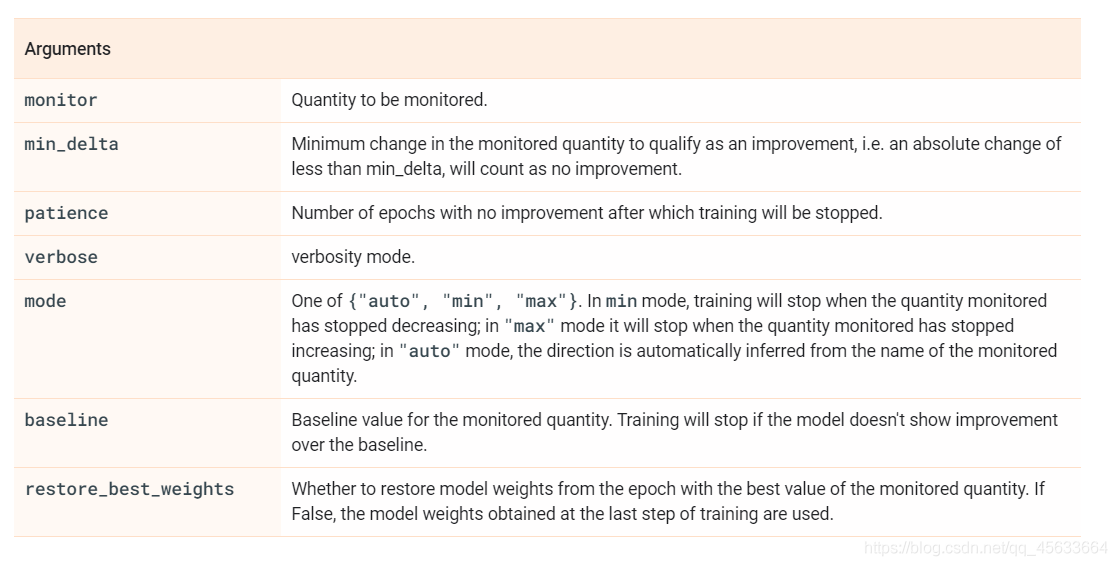


In [ ]:
#test
!pip install keras_bert
from keras.models import load_model
from keras_bert import get_custom_objects
from keras.metrics import Accuracy

custom_objects = get_custom_objects()
my_objects = {'accuracy': Accuracy}
custom_objects.update(my_objects)
model = load_model('/content/drive/MyDrive/AI_&_EdgeComputing_Program/NLP/NLP專案/專案程式碼(共用)/修改進度/bert_model.h5', custom_objects=custom_objects)

In [ ]:
import numpy as np
print(np.argmax(test_model_pred, axis = 1))
# print(test_model_pred)

NameError: ignored

In [ ]:
text_a = "李天一已被安排出国"
text_b = "李天一即将提前出狱？官方：是的！"
word_pieces = ["[CLS]"]
tokens_a = tokenizer.tokenize(text_a)
word_pieces += tokens_a + ["[SEP]"]
len_a = len(word_pieces)
        
tokens_b = tokenizer.tokenize(text_b)
word_pieces += tokens_b + ["[SEP]"]
len_b = len(word_pieces) - len_a

ids = tokenizer.convert_tokens_to_ids(word_pieces)
tokens_tensor = torch.tensor(ids).unsqueeze(0)
     
segments_tensor = torch.tensor([0] * len_a + [1] * len_b,dtype=torch.long).unsqueeze(0)

masks_tensors = torch.zeros(tokens_tensor.shape,dtype=torch.long)
masks_tensors = masks_tensors.masked_fill(tokens_tensor != 0, 1).unsqueeze(0)

outputs = model(input_ids=tokens_tensor.to(device),token_type_ids=segments_tensor.to(device),attention_mask=masks_tensors.to(device))
logits = outputs[0]
_, pred = torch.max(logits.data, 1)
label_map = {0:'agreed', 1: 'disagreed', 2: 'unrelated'}

print(outputs)
print(label_map[pred.cpu().tolist()[0]])


###參考: 
当Bert遇上Keras：这可能是Bert最简单的打开姿势https://kexue.fm/archives/6736
